# Deep Learning Human Skin Detection
---
Deep Learning model for human skin detection with application of:
* **pixel classification** based on:
    * only one pixel (i.e. values of R, G and B)
    * 5x5 neighbourhood of pixel (i.e. 5x5x3=75 values)
    * 9x9 neighbourhood of pixel (i.e. 9x9x3=243 values)
    * 13x13 neighbourhood of pixel (i.e. 13x13x3=507 values)
* **neural network with LSTM recurrent layer**

In [1]:
import os
import csv
import pickle

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torchvision import models
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchvision

from sklearn.metrics import accuracy_score, f1_score

from src.face_detector import inference
from src.visualize import show_images

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'MainModel.KitModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by access

## Data gathering
---
First detect faces on input images and their ground truths respectively.<br />
Load all detected faces with their ground truth masks. Then for each pixel in ground truth extract its neighbourhood from input image.<br />
Save every 3-rd pixel into validation set and others into train.

In [2]:
INPUT_IMG_PATH = 'skin_color_images/input'
GROUND_TRUTH_PATH = 'skin_color_images/ground_truth'

FACES_PATH = 'skin_color_images/faces'
FACES_GT_PATH = 'skin_color_images/faces_gt'

N = (5, 5)  # neighbourhood
FACTOR = 0.25  # factor for images shrinking (to reduce training time)

In [3]:
if len(os.listdir(FACES_PATH)) == 0:
    ctr = 0
    t = tqdm(os.listdir(INPUT_IMG_PATH))
    for img_name in t:
        
        t.set_postfix_str(f'Curr. img.: {img_name} | Faces found: {ctr}')
        img = Image.open(f'{INPUT_IMG_PATH}/{img_name}')
        img_arr = np.array(img)
        gt = Image.open(f'{GROUND_TRUTH_PATH}/{img_name.replace(".jpg", ".png")}')
        gt_arr = np.array(gt)
        
        try:
            faces, _ = inference(img_arr)
            for face in faces:
                fx1, fy1, fx2, fy2 = tuple(face[2:])
                
                face_img = Image.fromarray(img_arr[fy1:fy2, fx1:fx2])
                face_gt = Image.fromarray(gt_arr[fy1:fy2, fx1:fx2])
                face_img = face_img.resize((int(face_img.width*FACTOR), int(face_img.height*FACTOR)))
                face_gt = face_gt.resize((int(face_gt.width*FACTOR), int(face_gt.height*FACTOR)),
                                         resample=Image.NEAREST)
                face_img.save(f'{FACES_PATH}/face{ctr}.png')
                face_gt.save(f'{FACES_GT_PATH}/face{ctr}.png')
                
                ctr += 1
        except:
            pass

In [4]:
DATA_PATH = f'skin_color_images/data{N[0]}x{N[1]}'

In [5]:
if not os.path.exists(f'{DATA_PATH}_val.csv'):
    ctr = 0
    with open(f'{DATA_PATH}_val.csv', 'w') as f:
        pass
    with open(f'{DATA_PATH}_train.csv', 'w') as f:
        pass

    for img_name in tqdm(os.listdir(FACES_PATH)):
        img = Image.open(f'{FACES_PATH}/{img_name}')
        gt = Image.open(f'{FACES_GT_PATH}/{img_name}').convert('L')

        img_arr = np.zeros((img.size[1] + N[0]-1, img.size[0] + N[1]-1, 3))
        off0, off1 = N[0]//2, N[1]//2
        img_arr[off0:-off0, off1:-off1] = np.array(img)/255.
        gt_arr = np.array(gt)/255.

        for i in range(gt_arr.shape[0]):
            for j in range(gt_arr.shape[1]):
                file = f'{DATA_PATH}_{"val" if ctr%3 == 0 else "train"}.csv'
                with open(file, 'a') as f:
                    csv.writer(f).writerow([*img_arr[i:i+N[0], j:j+N[1]].reshape(-1), gt_arr[i, j]])
                ctr += 1

In [6]:
def get_rows(file, a, b):
    with open(file, 'r') as f:
        r = csv.reader(f)
        rows = list()
        for i in range(a):
            next(r)
        for i in range(a, b):
            rows.append(next(r))
    return np.array(rows).astype(float)

In [7]:
get_rows(f'{DATA_PATH}_train.csv', a=24, b=26)

array([[0.96470588, 0.77254902, 0.76862745, 0.96862745, 0.75686275,
        0.74117647, 0.8745098 , 0.61568627, 0.59215686, 0.43921569,
        0.21568627, 0.21960784, 0.19215686, 0.07058824, 0.10196078,
        0.76862745, 0.47058824, 0.44705882, 0.81960784, 0.57647059,
        0.56862745, 0.90980392, 0.6745098 , 0.6627451 , 0.62352941,
        0.40392157, 0.4       , 0.17647059, 0.05882353, 0.07843137,
        0.80784314, 0.5372549 , 0.50588235, 0.8       , 0.56862745,
        0.55686275, 0.93333333, 0.70588235, 0.67058824, 0.86666667,
        0.60392157, 0.56078431, 0.56862745, 0.27843137, 0.27058824,
        0.94509804, 0.74509804, 0.76078431, 0.98039216, 0.80392157,
        0.81568627, 0.96078431, 0.76078431, 0.74901961, 0.85490196,
        0.61176471, 0.58431373, 0.8627451 , 0.60392157, 0.56470588,
        0.89411765, 0.59215686, 0.57647059, 0.90980392, 0.61568627,
        0.58823529, 0.91764706, 0.65882353, 0.62352941, 0.8627451 ,
        0.61568627, 0.58823529, 0.89411765, 0.65

In [8]:
get_rows(f'{DATA_PATH}_val.csv', a=24, b=26)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.81568627, 0.47843137, 0.45490196, 0.79607843,
        0.46666667, 0.44705882, 0.82352941, 0.53333333, 0.50980392,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.83529412, 0.56078431, 0.52941176, 0.83137255,
        0.54509804, 0.53333333, 0.88627451, 0.64705882, 0.64313725,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.6       , 0.38039216, 0.37254902, 0.88627451,
        0.61176471, 0.63137255, 0.90980392, 0.64705882, 0.6745098 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.20392157, 0.09803922, 0.10980392, 0.69019608,
        0.48235294, 0.50196078, 0.91764706, 0.68627451, 0.69411765,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

## Model
---
Implementation of PyTorch Model and Dataset.

In [9]:
INPUT_SIZE = 5*5*3  # 5x5 dimensions, 3 values of pixel i.e. 75 features
OUTPUT_SIZE = 2

In [10]:
EPOCHS = 10
LR = 0.001
MOMENTUM = 0.9

BS = 500

BEST_MODEL_PATH = 'src/models/hsdetection_best.pt'
MODEL_PATH = 'src/models/hsdetection.pt'

In [11]:
class HumanSkinDataset(Dataset):
    def __init__(self, path=None, data=None, is_test=False):
        
        assert path or data, 'Error! You must either provide a path to dataset or pass the data directly!'
        
        self.is_test = is_test
        if not is_test:
            self.path = path
            with open(path, 'r') as f:
                self.data = np.array(list(csv.reader(f))).astype(float)
        else:
            self.data = np.array(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        
        x = torch.tensor(item[:-1] if not self.is_test else item).float().reshape((1, INPUT_SIZE))
        y = F.one_hot(torch.tensor(item[-1:]).to(torch.int64), OUTPUT_SIZE)

        return x, y if not self.is_test else x
    
    def collate_fn(self, batch):
        features = list()
        labels = list()

        for b in batch:
            features.append(b[0])
            labels.append(b[1])

        features = torch.stack(features, dim=0)
        labels = torch.cat(labels, dim=0)

        return features, labels

In [12]:
class HumanSkinModel(torch.nn.Module):
    def __init__(self, input_len, output_len):
        super(HumanSkinModel, self).__init__()
        
        self.lstm = torch.nn.LSTM(input_len, 500, 25)
        self.lstm_drop = torch.nn.Dropout(0.1)
        self.fc0 = torch.nn.Linear(500, 500)
        self.fc0_drop = torch.nn.Dropout(0.1)
        self.fc1 = torch.nn.Linear(500, 500)
        self.fc1_drop = torch.nn.Dropout(0.1)
        self.fc2 = torch.nn.Linear(500, output_len)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.lstm_drop(x)
        x = F.relu(self.fc0(x))
        x = self.fc0_drop(x)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.log_softmax(self.fc2(x))
        return x


In [13]:
train_ds = HumanSkinDataset(f'{DATA_PATH}_train.csv')
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=False, collate_fn=train_ds.collate_fn)

valid_ds = HumanSkinDataset(f'{DATA_PATH}_val.csv')
valid_dl = DataLoader(valid_ds, batch_size=BS, shuffle=False, collate_fn=valid_ds.collate_fn)

In [14]:
model = HumanSkinModel(input_len=INPUT_SIZE, output_len=OUTPUT_SIZE)

criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

In [15]:
def calculate_metrics(pred, true):
    pred = torch.argmax(pred, dim=1).numpy()
    true = true.numpy()
    
    a = accuracy_score(y_pred=pred, y_true=true)
    f0, f1 = f1_score(y_pred=pred, y_true=true, labels=[0, 1], average=None)
    
    return a, f0, f1

In [16]:
if not os.path.exists(MODEL_PATH):
    last_valid_loss = 10.

    for epoch in range(EPOCHS):
        # training step
        model.train()
        train_loss = []

        t = tqdm(train_dl, leave=False)
        for step, (features, labels) in enumerate(t):
            optimizer.zero_grad()

            pred = model(features)

            pred = torch.flatten(pred, 1)
            labels = torch.argmax(labels, dim=1)
            a, f0, f1 = calculate_metrics(pred, labels)

            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            t.set_postfix_str(f'Epoch: {epoch+1}/{EPOCHS} | Step: {step+1}/{len(train_dl)} | ' +
                              f'Train loss: {str(np.round(loss.item(), 4))} | ' +
                              f'Acc.: {str(np.round(a, 4))} | ' +
                              f'F0/1: {str(np.round(f0, 4))}/{str(np.round(f1, 4))}')

        # validation step
        model.eval()
        valid_loss = []

        with torch.no_grad():
            t = tqdm(valid_dl, leave=False)
            for step, (features, labels) in enumerate(t):
                pred = model(features)

                pred = torch.flatten(pred, 1)
                labels = torch.argmax(labels, dim=1)
                a, f0, f1 = calculate_metrics(pred, labels)

                loss = criterion(pred, labels)
                valid_loss.append(loss.item())
                t.set_postfix_str(f'Epoch: {epoch+1}/{EPOCHS} | Step: {step+1}/{len(valid_dl)} | ' +
                                  f'Train loss: {str(np.round(loss.item(), 4))} | ' +
                                  f'Acc.: {str(np.round(a, 4))} | ' +
                                  f'F0/1: {str(np.round(f0, 4))}/{str(np.round(f1, 4))}')

        curr_train_loss = np.mean(train_loss)
        curr_valid_loss = np.mean(valid_loss)

        print('Epoch:', epoch+1, '/', EPOCHS,
                '\tTrain loss:', '{:.4f}'.format(np.mean(train_loss)),
                '\tValid. loss:', '{:.4f}'.format(np.mean(valid_loss)))

        # save model if validation loss is better than from the previous epoch
        if last_valid_loss >= curr_valid_loss:
            torch.save(model, BEST_MODEL_PATH)
            print(f'Model saved! Validation loss improved by: {np.round(last_valid_loss - curr_valid_loss, 4)}')
            last_valid_loss = curr_valid_loss

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 / 10 	Train loss: 6.1919 	Valid. loss: 6.1619
Model saved! Validation loss improved by: 3.8381


Epoch: 2 / 10 	Train loss: 6.1919 	Valid. loss: 6.1619
Model saved! Validation loss improved by: 0.0


Epoch: 3 / 10 	Train loss: 6.1919 	Valid. loss: 6.1619


Epoch: 4 / 10 	Train loss: 6.1919 	Valid. loss: 6.1619


Epoch: 5 / 10 	Train loss: 6.1919 	Valid. loss: 6.1619


Epoch: 6 / 10 	Train loss: 6.1920 	Valid. loss: 6.1619


Epoch: 7 / 10 	Train loss: 6.1919 	Valid. loss: 6.1619


Epoch: 8 / 10 	Train loss: 6.1920 	Valid. loss: 6.1619
Model saved! Validation loss improved by: 0.0


Epoch: 9 / 10 	Train loss: 6.1920 	Valid. loss: 6.1619


Epoch: 10 / 10 	Train loss: 6.1920 	Valid. loss: 6.1619


In [17]:
torch.save(model, MODEL_PATH)

del train_ds, train_dl, valid_ds, valid_dl

In [18]:
model = torch.load(MODEL_PATH)
model

HumanSkinModel(
  (lstm): LSTM(75, 500, num_layers=25)
  (lstm_drop): Dropout(p=0.1, inplace=False)
  (fc0): Linear(in_features=500, out_features=500, bias=True)
  (fc0_drop): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=500, out_features=500, bias=True)
  (fc1_drop): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
)

In [33]:
def detect_skin(image, return_array=False):
    
    img_arr = np.zeros((image.size[1] + N[0]-1, image.size[0] + N[1]-1, 3))
    off0, off1 = N[0]//2, N[1]//2
    img_arr[off0:-off0, off1:-off1] = np.array(image)/255.
    gt_arr = np.zeros((image.size[1], image.size[0]))
    
    features_list = list()
    for i in range(gt_arr.shape[0]):
        for j in range(gt_arr.shape[1]):
            features_list.append(img_arr[i:i+N[0], j:j+N[1]].reshape(-1))
    
    test_ds = HumanSkinDataset(data=features_list, is_test=True)
    test_dl = DataLoader(test_ds, batch_size=BS, shuffle=False, collate_fn=test_ds.collate_fn)
    
    preds_list = list()
    with torch.no_grad():
        t = tqdm(test_dl, leave=False)
        for step, (features, labels) in enumerate(t):
            pred = model(features)
            preds_list.append(torch.argmax(pred, dim=2).reshape(1, -1).numpy().flatten())
    
    del test_ds, test_dl
    
    pred_img_arr = np.hstack(preds_list).reshape(gt_arr.shape).astype(float)
    pred_img_arr[pred_img_arr==1] = 255
    
    if return_array:
        return pred_img_arr
    
    pred_img = Image.fromarray(pred_img_arr)
    return pred_img

In [39]:
img1 = Image.open('skin_color_images/input/w_sexy.jpg')
skn1 = Image.open('skin_color_images/ground_truth/w_sexy.png')
res1 = detect_skin(img1)

img2 = Image.open('skin_color_images/input/sara_badr.jpg')
skn2 = Image.open('skin_color_images/ground_truth/sara_badr.png')
res2 = detect_skin(img2)

img3 = Image.open('skin_color_images/input/josh-hartnett-Poster-thumb.jpg')
skn3 = Image.open('skin_color_images/ground_truth/josh-hartnett-Poster-thumb.png')
res3 = detect_skin(img3)

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


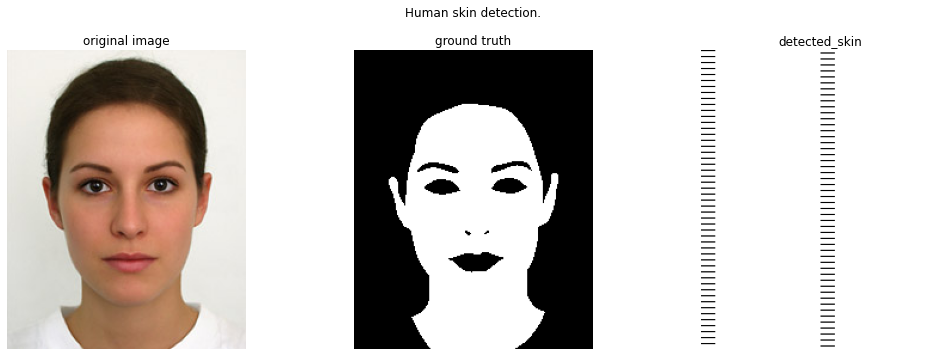

In [40]:
show_images([img1, skn1, res1], ['original image', 'ground truth', 'detected_skin'],
            suptitle='Human skin detection.')

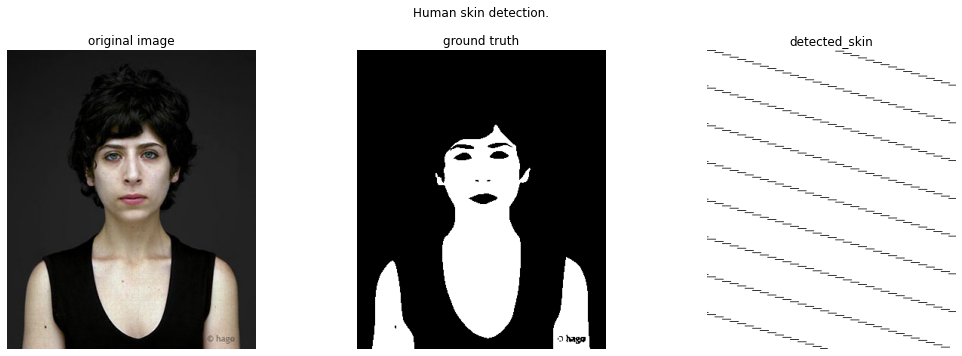

In [41]:
show_images([img2, skn2, res2], ['original image', 'ground truth', 'detected_skin'],
            suptitle='Human skin detection.')

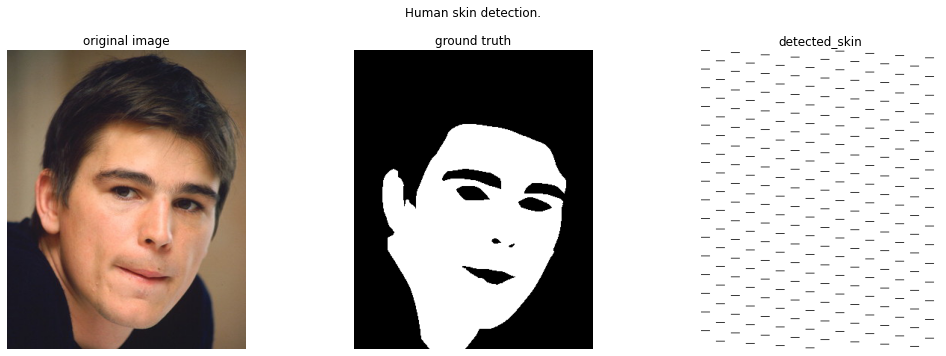

In [42]:
show_images([img3, skn3, res3], ['original image', 'ground truth', 'detected_skin'],
            suptitle='Human skin detection.')